This notebook is meant to run on server where data has been downloaded.

In [1]:
%load_ext autoreload
%autoreload 2

In [15]:
import numpy as np
from rtc_seq_dataset import SeqDistDataset, open_rtc_table
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt
import torch

In [3]:
seed = torch.Generator().manual_seed(42)

In [4]:
%%time

df_rtc = open_rtc_table()

CPU times: user 2 s, sys: 882 ms, total: 2.88 s
Wall time: 2.96 s


This cell is what needs modification if running notebook elsewhere:

- `root` is where data is downloaded
- `download` is `True` indicates looking for data

The dataset basically checks if data already exists and this takes a few minutes if data has been previous downloaded to compile the columns of paths based on `root`.

In [17]:
%%time

seq_dataset = SeqDistDataset(download=False, 
                             n_pre_imgs=4, 
                             df_rtc_meta=df_rtc)

CPU times: user 163 ms, sys: 0 ns, total: 163 ms
Wall time: 163 ms


In [20]:
for i, data in enumerate(seq_dataset):
    break

# data

tv for vh: 100%|███████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 39.95it/s]


In [21]:
def collate_fn(batch):
    pre_imgs_b = torch.stack([item['pre_imgs'] for item in batch], dim=0).float()
    post_img_b = torch.stack([item['post_img'] for item in batch], dim=0).float()
    nodata_mask_b = torch.stack([item['nodata_masks'] for item in batch], dim=0)

    out = {'pre_imgs': pre_imgs_b,
           'post_img': post_img_b,
           'nodata_masks':  nodata_mask_b,
           }
    return out

In [22]:
%%time

train_dataset, val_dataset, test_dataset = random_split(seq_dataset, [.6, .2, .2], generator=seed)

CPU times: user 523 μs, sys: 187 μs, total: 710 μs
Wall time: 609 μs


In [23]:
%%time

train_dataloader = DataLoader(train_dataset, batch_size=4, shuffle=True, collate_fn=collate_fn)
val_dataloader = DataLoader(val_dataset, batch_size=4, shuffle=True, collate_fn=collate_fn)
test_dataloader = DataLoader(test_dataset, batch_size=4, shuffle=True, collate_fn=collate_fn)

CPU times: user 231 μs, sys: 0 ns, total: 231 μs
Wall time: 236 μs


In [24]:
%%time
dl = iter(train_dataloader)

CPU times: user 899 μs, sys: 971 μs, total: 1.87 ms
Wall time: 1.63 ms


The first next takes longest - not sure what the bottleneck is at initialization.

In [25]:
%%time

batch = next(dl)

tv for vh: 100%|███████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 39.95it/s]


CPU times: user 3.05 s, sys: 452 ms, total: 3.5 s
Wall time: 38.4 s


In [26]:
%%time
pre_imgs = batch['pre_imgs'].cpu().numpy()
nodata_masks = batch['nodata_masks'].cpu().numpy()

CPU times: user 198 μs, sys: 47 μs, total: 245 μs
Wall time: 208 μs


In [27]:
# B x T x H x W --> B x 1 x H x W --> B x 2 x H x W
M_t = batch['nodata_masks'].any(1, keepdim=True).expand((-1, 2, -1, -1))
M = M_t.cpu().numpy()
M.shape

(4, 2, 224, 224)

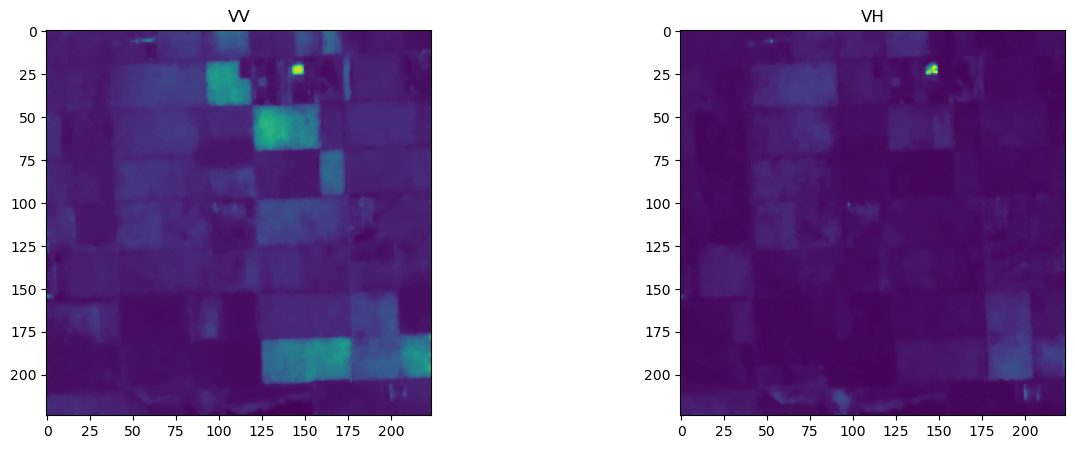

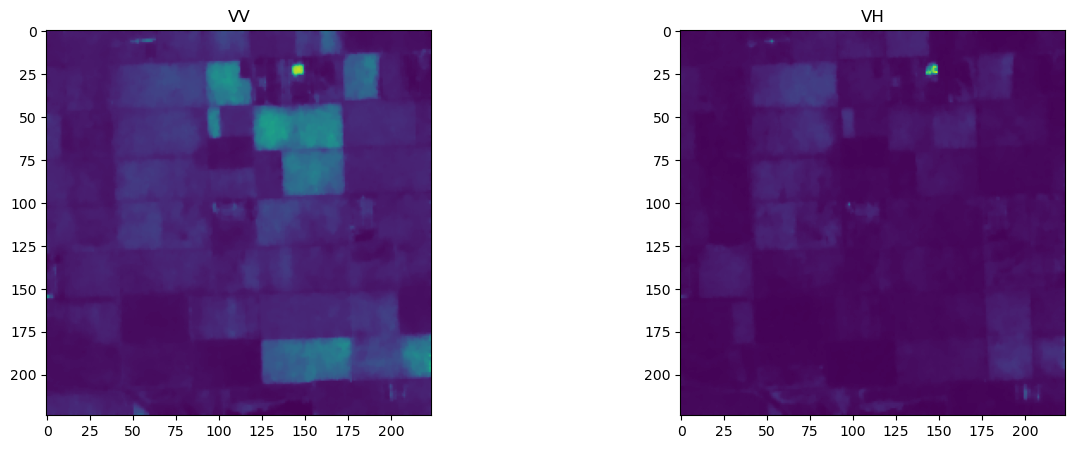

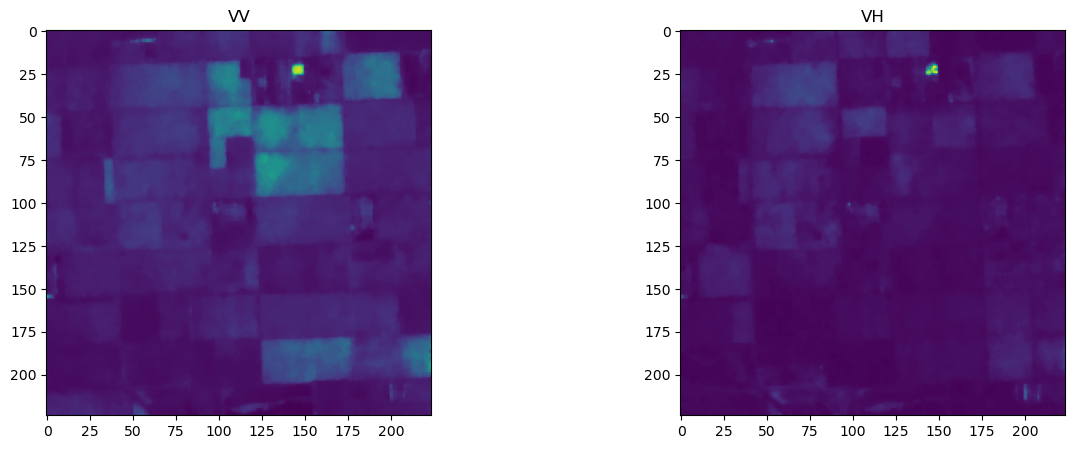

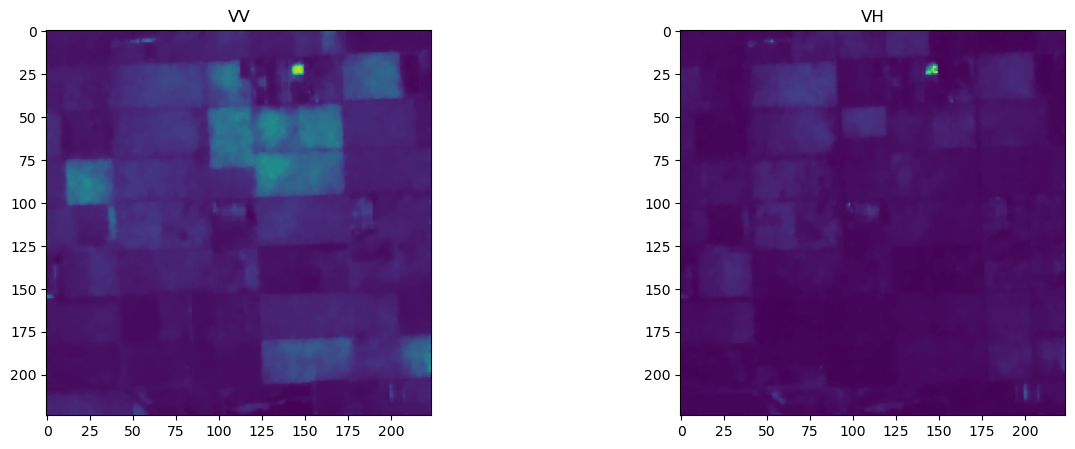

In [28]:
batch_ind = 2

for pre_img_ind in range(4):
    m = M[batch_ind, 0, ...]
    vv = pre_imgs[batch_ind, pre_img_ind, 0, ...]
    vh = pre_imgs[batch_ind, pre_img_ind, 1, ...]

    vv[m] = np.nan
    vh[m] = np.nan
    
    fig, axs = plt.subplots(1, 2, figsize=(15, 5))
    axs[0].imshow(vv, vmin=0, vmax=.7)
    axs[0].set_title('VV')
    axs[1].imshow(vh, vmin=0, vmax=.15)
    axs[1].set_title('VH')
    plt.show()

## Unet

In [28]:
import pytorch_lightning as pl
from unet import Unet

In [29]:
decoder_channels = [int(224 / 2** i) for i in range(5)]
decoder_channels

[224, 112, 56, 28, 14]

In [30]:
MODEL = Unet(backbone='resnet50',
             backbone_kwargs=None,
             backbone_indices=None,
             decoder_use_batchnorm=True,
             decoder_channels=decoder_channels,
             in_chans= seq_dataset.n_pre_imgs * 2,
             # Two polarizations out
             num_classes=2
            )

In [31]:
decoder_channels = [int(224 / 2** i) for i in range(5)]
decoder_channels

[224, 112, 56, 28, 14]

In [35]:
import torch.nn.functional as F

class UnetAutoencoder(pl.LightningModule):
    def __init__(self, ):
        super().__init__()
        model = Unet(backbone='resnet50',
                     backbone_kwargs=None,
                     backbone_indices=None,
                     decoder_use_batchnorm=True,
                     decoder_channels=decoder_channels,
                     in_chans= seq_dataset.n_pre_imgs * 2, 
                     num_classes=2)
        self.unet = model

    def training_step(self, batch, batch_idx):
        pre_imgs = batch['pre_imgs']
        post_img = batch['post_img']
        mask = batch['nodata_masks']

        mask_target = batch['nodata_masks'].any(1, keepdim=True).expand((-1, 2, -1, -1))

        
        # preimgs are B X T X 2 X H X W --> B X (T * 2) X H X W
        x_hat = self.unet(pre_imgs.flatten(1, 2))

        # data_mask
        x_hat_mask = x_hat[~mask_target]
        post_image_mask = post_img[~mask_target]
        loss = F.mse_loss(x_hat_mask, post_image_mask)
        return loss

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-3)
        return optimizer

In [36]:
l_model = UnetAutoencoder()

In [37]:
# train model
trainer = pl.Trainer()
trainer.fit(model=l_model, train_dataloaders=train_dataloader)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name | Type | Params | Mode 
--------------------------------------
0 | unet | Unet | 31.3 M | train
--------------------------------------
31.3 M    Trainable params
0         Non-trainable params
31.3 M    Total params
125.125   Total estimated model params size (MB)


Training: |                                                                        | 0/? [00:00<?, ?it/s]


loading vv: 100%|██████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 16.38it/s]

loading vh: 100%|██████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 31.44it/s]

tv for vv: 100%|███████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 45.50it/s]

tv for vh: 100%|███████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 37.34it/s]

loading vv: 100%|██████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 21.79it/s]

loading vh: 100%|██████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 37.87it/s]

tv for vv: 100%|███████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 30.89it/s]

tv for vh: 100%|███████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 39.13it/s]

loading vv: 100%|██████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  6.54it/s]

loading vh: 100%|███████████████████